## Combined reference and target images for image making

In [1]:
import json
import integrated_cell
from integrated_cell import model_utils, utils
import os
import numpy as np
import torch

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

from integrated_cell.utils.plots import tensor2im, imshow

gpu_ids = [1]
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(ID) for ID in gpu_ids])
if len(gpu_ids) == 1:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True

torch.cuda.empty_cache()
    
model_dir = '/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04'
parent_dir = '/allen/aics/modeling/gregj/results/integrated_cell/'
suffix = '_94544'    

networks, dp_ref, args_ref = utils.load_network_from_dir(model_dir, parent_dir, suffix=suffix)

ref_enc = networks['enc']
ref_dec = networks['dec']

parent_dir = '/allen/aics/modeling/gregj/results/integrated_cell/'
model_dir = "/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/"
suffix = '_93300'

networks, dp_target, args_target = utils.load_network_from_dir(model_dir, parent_dir, suffix=suffix)
    
target_enc = networks['enc']
target_dec = networks['dec']


results_dir = '{}/results/ref_target_images/'.format(parent_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
print("Results dir: {}".format(results_dir))

save_dir = results_dir

/allen/aics/modeling/rorydm/projects/pytorch_integrated_cell/integrated_cell/utils/utils.py:75: UserWarning: args file exists and overwrite is not set to True. Using existing args file.
  "args file exists and overwrite is not set to True. Using existing args file."


loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04/ref_model/enc_94544.pth
loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04/ref_model/dec_94544.pth
loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/ref_model/enc_93300.pth
loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/ref_model/dec_93300.pth
Results dir: /allen/aics/modeling/gregj/results/integrated_cell//results/ref_target_images/


In [2]:
from aicsimageio.writers import OmeTiffWriter

def im_write(im, path):
    im = im.cpu().detach().numpy().transpose(3,0,1,2)
    
    with OmeTiffWriter(path, overwrite_file=True) as writer:
        writer.save(im)

In [3]:
from integrated_cell.networks.ref_target_autoencoder import Autoencoder


mode = 'test'
dp = dp_target
u_classes, class_inds = np.unique(dp.get_classes(np.arange(0, dp.get_n_dat(mode)), mode), return_inverse=True)
u_class_names = dp.label_names[u_classes]

ae = Autoencoder(ref_enc, ref_dec, target_enc, target_dec)
ae.train(False)
ae = ae.cuda()



In [4]:
target, labels, ref = dp.get_sample(mode)
label_onehot = utils.index_to_onehot(labels, len(u_classes)).cuda()
target = target.cuda()
ref = ref.cuda()

with torch.no_grad():
    target_hat, ref_hat = ae(target, ref, label_onehot)

im = torch.cat([ref[:,[0]], target, ref[:,[1]]], 1)
im_hat = torch.cat([ref_hat[:,[0]], target_hat, ref_hat[:,[1]]], 1)

## Save Real and Autoencoded Images

In [5]:
import integrated_cell.utils.plots as plots
import tqdm

ae_dir = "./images/ae/"
if not os.path.exists(ae_dir):
    os.makedirs(ae_dir)        
        
c = 0
for i in tqdm.tqdm(range(10)):
        
    target, labels, ref = dp.get_sample(mode)
    label_onehot = utils.index_to_onehot(labels, len(u_classes)).cuda()
    target = target.cuda()
    ref = ref.cuda()

    with torch.no_grad():
        target_hat, ref_hat = ae(target, ref, label_onehot)

    im = torch.cat([ref[:,[0]], target, ref[:,[1]]], 1)
    im_hat = torch.cat([ref_hat[:,[0]], target_hat, ref_hat[:,[1]]], 1)

    for i, [im_, im_hat_, structure_type] in enumerate(zip(im, im_hat, u_class_names[labels])):
        im_write(im_, "{}/{}_im{}_real.tiff".format(ae_dir, structure_type, c))
        im_write(im_hat_, "{}/{}_im{}_ae.tiff".format(ae_dir, structure_type, c))    
        
        c+=1


100%|██████████| 10/10 [04:53<00:00, 29.32s/it]


In [6]:
structures_to_gen = ["Mitochondria", 'Nuclear envelope', 'Tight junctions']
# structures_to_gen = [c for c in u_class_names if "Control - " not in c]

structure_ids_to_gen = np.stack([np.where(u_class_names == structure)[0] for structure in structures_to_gen])

structure_to_gen_ids = [np.where(class_inds == structure_id)[0] for structure_id in structure_ids_to_gen]
    
#i chose these
structure_to_gen_inds = [1, 0, 0]

im_ids = [structure_to_gen[ind] for structure_to_gen, ind in zip(structure_to_gen_ids, structure_to_gen_inds)]


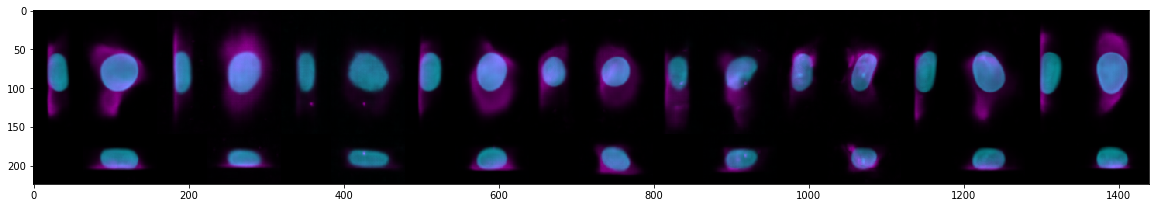

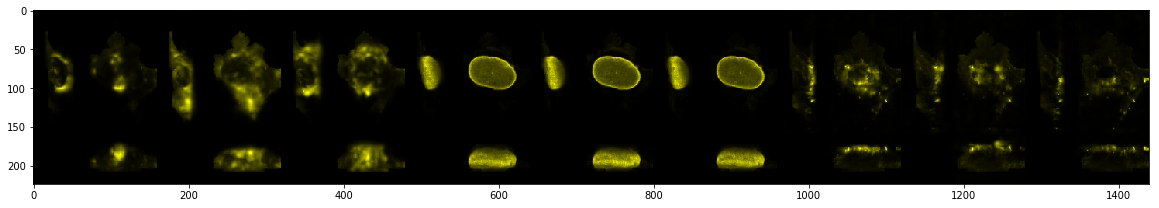

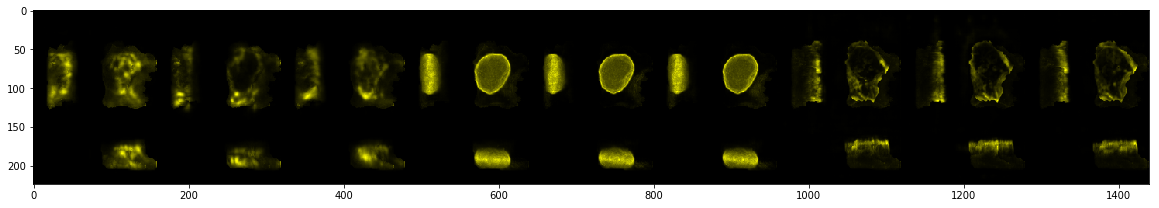

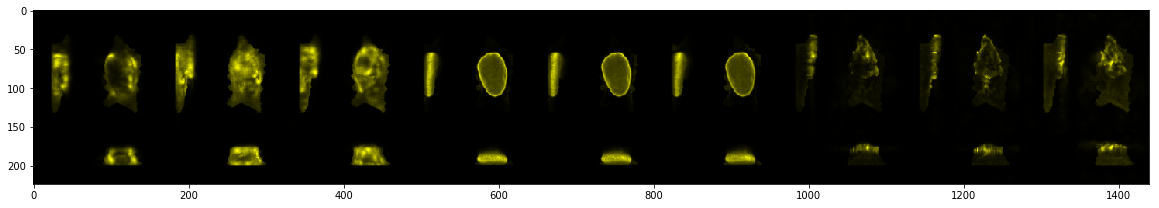

In [7]:
from matplotlib.image import imsave as imsave

gen_dir = "./images/gen/"
if not os.path.exists(gen_dir):
    os.makedirs(gen_dir)   
    
n_structures = len(structures_to_gen)
n_imgs_per_structure = 3

n_cols = int(n_structures*n_imgs_per_structure)

target, label, ref = dp.get_sample(mode, im_ids)
label_onehot = utils.index_to_onehot(label, len(u_classes)).cuda()

target = target.cuda()
ref = ref.cuda()

im = torch.cat([ref[:,[0]], target, ref[:,[1]]], 1)

reals = list()
for i in range(n_structures):
    real = plots.tensor2im(im[[i]])
    imsave("{}/real_{}.png".format(gen_dir, structures_to_gen[i]), real)
    
    im_tmp = im[[i]]
    im_tmp[:, [0,2]] = 0
    real_no_ref = plots.tensor2im(im_tmp)
    
    imsave("{}/real_{}_no_ref.png".format(gen_dir, structures_to_gen[i]), real_no_ref)
    
    
    reals.append(plots.tensor2im(ref[[i]]))
    
imsave("{}/real_ref.png".format(gen_dir), np.hstack(reals))
    

#generate 9 cell and nuc images by passing in only labels into the AE
labels_onehot_dummy = torch.zeros([n_cols, len(u_classes)]).float().cuda()

with torch.no_grad():
    _, ref_gen = ae(target=None, ref=None, labels = labels_onehot_dummy)

gen_ref = np.hstack([plots.tensor2im(ref_gen[[i]]) for i in range(ref_gen.shape[0])])    

imsave("{}/gen_ref.png".format(gen_dir), gen_ref)
    
plt.figure(figsize=[20,20])
plt.imshow(gen_ref)
    
labels_gen = torch.cat([label_onehot[[i]].repeat([n_imgs_per_structure,1]) for i in range(n_structures)],0)

for i in range(n_structures):
    ref_tmp = ref[[i]].repeat([n_cols, 1, 1, 1, 1])
    
    target_gen, _ = ae(target=None, ref=ref_tmp, labels = labels_gen)
    
    gen_imgs = np.hstack([plots.tensor2im(target_gen[[i]], color_transform=[[1,1,0]]) for i in range(target_gen.shape[0])])
    
#     imsave("{}/gen_{}.png".format(gen_dir, structures_to_gen[i]), gen_imgs)
    
    plt.figure(figsize=[20,20])
    plt.imshow(gen_imgs)
    plt.show()
    plt.close()


In [8]:
label_onehot = utils.index_to_onehot(label, len(u_classes))
label_onehot.dtype
# label_onehot = label_onehot.cuda()

torch.float32

In [9]:
im = torch.cat([ref[:,[0]], target, ref[:,[1]]], 1)


In [10]:
for u_label in np.unique(dp_ref.labels):
    n_labels = np.sum(dp_ref.labels == u_label)
    label_name = dp_ref.label_names[u_label]
    print(f"{label_name}: {n_labels}")

Actin filaments: 2848
Actomyosin bundles: 1392
Adherens junctions: 2343
Centrosome: 1605
Control - Blank: 2028
Control - DNA: 2028
Control - Memb: 2028
Control - Noise: 2028
Control - Random: 2028
Desmosomes: 2320
Endoplasmic reticulum: 1120
Endosomes: 1562
Gap junctions: 1491
Golgi: 1539
Lysosome: 1476
Matrix adhesions: 1637
Microtubules: 2409
Mitochondria: 3826
Nuclear envelope: 3664
Nucleolus (Dense Fibrillar Component): 1536
Nucleolus (Granular Component): 3717
Peroxisomes: 1455
Plasma membrane: 2098
Tight junctions: 1162
